# Otimização dos parâmetros de um desacelerador Zeeman

#### Bibliotecas

In [11]:
import mloop.interfaces as mli
import mloop.controllers as mlc
import mloop.visualizations as mlv

Outras bibliotecas úteis

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
from scipy import integrate
import time

#### Parâmetros

| Parâmetro | Valor | Definição |
| :---: |:---:| :---: |
| ```decay_rate```            |  | Taxa de decaimento da população excitada. |
| ```transition_wavelength``` |  | Comprimento de onda da transição utilizada para o resfriamento. |

In [13]:
decay_rate = 37*10**6

In [14]:
transition_wavelength = 780*10**-9

In [15]:
transition_frequency =  2*np.pi*constants.c/transition_wavelength

In [16]:
saturation_parameter = 3

In [17]:
detuning = -1.3*decay_rate

In [18]:
mass = 1.4*10**-25

## Código

#### Dinâmica

O campo pode ser ajustado para gerar o desvio Doppler apropriado ao longo do caminho do átomo. Para uma desaceleração uniforme $a\equiv\eta a_{\max}$ a partir de uma velocidade inicial $v_0$, o campo apropriado é 

$$B(z) = B_0\sqrt{1-z/z_0}$$

onde $z_0 \equiv Mv_0^2/\eta\hbar k\gamma$ é o comprimento do imã, e $B_0 = \hbar k v_0/\mu^\prime$. $\mu^\prime \equiv (g_e M_e  - g_g M_g)\mu_B$, $g_{g,e}$ sendo o fator de de Landé, $\mu_b$ o magneton de Bohr e $M_{g,e}$ o número quântico magnético. O parâmetro de desenho $\eta<1$ determina o comprimento $z_0$. 

A equação do movimento de um atomo no imã não pode ser, em geral, facilmente resolvida devido à força dependente de velocidade, mas este problema pode ser encarado por uma transformação para um referencial desacelerado $\mathcal{R}$. Para o caso especial de desaceleração uniforme, a velocidade relativa desse referencial no laboratório é $v_\mathcal{R} = v_0 \sqrt{1-z/z_0}$, e o desvio Doppler assocaido a essa velocidade é compensado pelo desvio Zeeman no imã, que depende da posição. A equação do movimento resultante para a velocidade dos átomos $v^\prime \equiv v - v_\mathcal{R}$ é 

$$M \frac{d\mathbf{v}^\prime}{dt} = -\mathbf{F}_{\text{max}}\left[\frac{s_0}{1+s_0+\left(2(\delta-\mathbf{k}\cdot\mathbf{v}^\prime)/\gamma\right)^2}-\eta\right]$$

onde $F_{max} = \hbar k \gamma/2$. Para o estado estacionário $dv^\prime/dt = 0$, a velocidade $v_{ss}^\prime$ é dada por 

$$kv^\prime_{ss} = \delta \pm \frac{\gamma}{2}\sqrt{s_0\frac{1-\eta}{\eta}-1}$$

Há dois valores, mas o com sinal positivo é instável. A magnitude é tipicamente da ordem de $\delta/k$. Esta velocidade se torna aproximadamente constante conforme o átomo se move ao longo do imã e o decrescente desvio Doppler é compensando pelos decrescentes desvios Zeeman.

In [19]:
def Bfield(z_0,z):
    """
    Parameters
    ----------
    z_0 : float
        Magnet length
    """
    B_0 = 1
    B_z = B_0*np.sqrt(1-z/z_0)
    return B_z

In [20]:
def rel_acceleration(rel_v, t_0, k, s_0, delta, gamma, eta, M):
    """
    Parameters
    ----------
    rel_v : numpy array
        Atomic velocity relative to the accelerated frame
    
    k : numpy array
        Laser wavevector
        
    s_0 : float
        Intensity parameter
        
    delta : float
        Detuning
        
    gamma : float
        Decay rate of the excited state
        
    eta : float
        Design parameter of the magnet
        
    M : float
        Atomic mass
        
    Returns
    -------
    rel_a : numpy array
        Atomic acceleration relative to the accelerated frame
    """
    F_max = (constants.hbar*gamma/2)*k
    rel_a_factor = eta - s_0/(1+s_0+(2*(delta + np.dot(k,rel_v))/gamma)**2)
    rel_a = (F_max*rel_a_factor)/M
    
    return rel_a

In [21]:
v0 = np.array([0,0,500])
k = np.array([0,0,-(transition_frequency+detuning)/constants.c])
eta = 0.1
times = np.linspace(0,10e-9,1000)
print(v0,type(v0))

[  0   0 500] <class 'numpy.ndarray'>


rel_acceleration(v0, times, k, saturation_parameter*constants.hbar*k*decay_rate, detuning, decay_rate, eta, mass)

%time
integrate.odeint(rel_acceleration, v0, times, args = (k, saturation_parameter*constants.hbar*k*decay_rate, detuning, decay_rate, eta, mass))

In [22]:
class ZeemanDeceleratorDynamics():
    
    def __init__(self,v0,z0):
        self.initial_velocity = v0
        self.initial_relative_velocity = np.zeros(3)
        self.initial_speed = np.linalg.norm(v0)
        self.magnet_length = z0
        self._stop = False
        
    def relative_acceleration(self, rel_v, t, k, s0, delta, gamma, eta, M):
        #print('acc_args',rel_v, t, k, s0, delta, gamma, eta, M)
        F_max = (constants.hbar*gamma/2)*k
        rel_a_factor = eta - s0/(1+s0+(2*(delta - np.dot(k,rel_v))/gamma)**2)
        rel_a = (F_max*rel_a_factor)/M
        return rel_a

    def _generate_times(self, end, step):
        self._times = np.arange(0,end,step)
        
    def _generate_relative_speeds(self, args):
        self._speeds = integrate.odeint(self.relative_acceleration, self.initial_relative_velocity, self._times, args = args)
        
    def _get_lab_speed(self, relative_speed, position):
        z = position[2]
        if z < self.magnet_length:
            frame_rel_speed = np.array([0,0,self.initial_speed*np.sqrt(1-z/self.magnet_length)])
            lab_speed = relative_speed + frame_rel_speed
            return lab_speed
        else:
            self._stop = True
    
    def _generate_movement_landscape(self,step):
        dynamics = []
        t_counter = 0
        position = np.zeros(3)
        for time in self._times:
            speed = self._get_lab_speed(self._speeds[t_counter], position)
            if self._stop:
                break
            else:
                #print(position,'position')
                dynamics.append([time,position.copy(),speed.copy()])
                #print(dynamics)
                position += step*speed
                t_counter += 1
        self.dynamics = np.array(dynamics)
        
    def solve(self, end_time, step, speed_gen_args):
        #print('Starting solve')
        self._generate_times(end_time,step)
        #print('times generated as ', self._times)
        self._generate_relative_speeds(speed_gen_args)
        #print('speeds generated as', self._speeds)
        self._generate_movement_landscape(step)
        #print('movement landscape generated as', self.dynamics)


In [23]:
v0 = np.array([0,0,500])
vv0 = np.linalg.norm(v0)
kk = np.linalg.norm(k)
z0 = mass*vv0**2/(eta*constants.hbar*kk*decay_rate)
args = (k, saturation_parameter*constants.hbar*kk*decay_rate, detuning, decay_rate, eta, mass)
type(args) 
args
z0

11.135376596983091

In [24]:
decelerator = ZeemanDeceleratorDynamics(v0,z0)

In [32]:
%time
decelerator.solve(5*10e-3, 10e-9, args)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs


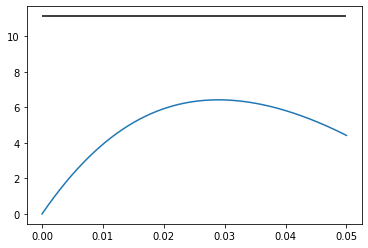

In [33]:
zeeman_pos = decelerator.dynamics[:,1]
zeeman_times = decelerator.dynamics[:,0]
zeeman_zs = []
for pos in zeeman_pos:
    zeeman_zs.append(pos[2])
plt.plot(zeeman_times,zeeman_zs)
plt.hlines(z0,0,0.05)

#### Interface

In [5]:
class MOTinterface(mli.Interface):
    """M-LOOP interface for a Python-controlled
    magneto-optical trap.
    
    Parameters
    ----------
    decay_rate : float
        Decay rate of the excited state of the element to
        be cooled.
    
    transition_wavelength : float
        Wavelength associated to energy level transition
        being exploided por atomic cooling.
        
    transition_frequency : float
        Frequency corresponding to transition_wavelength.
    """
    
    def __init__(self, decay_rate, transition_wavelength):
        super(MOTinterface,self).__init__()
        self.decay_rate = decay_rate
        self.transition_wavelength = transition_wavelength
        self.transition_frequency = 2*np.pi*constants.c/self.transition_wavelength
        
    def mot_force(self,u,z,S,d,dB):
        """Evaluates the force exerted on an atom with velocity
        u at position z along a one-dimensional magneto-optical
        trap, so that this force is due to two counter-propagating
        beams and a varying magnetic field.
    
        Parameters
        ----------
        u : float
        Velocity of the atom, on a scale of gamma/k.
        
        z : float
            Position of the atom along the traps.
        
        S : float
            Saturation parameter of the laser beams, which have
            identical intensities. Equal to the ratio between
            the laser intensity and the saturation intensity of
            the electronic transition.
        
        d : float
            Detuning of the laser frequency from the transition
            frequency.
        
        dB : float
            Constant magnetic gradient along the trap.
        
        Returns
        -------
        scaled_total_force : float
            Total force exerted on the atom given the chosen
            parameters, scaled by hbar*k*gamma.
        """
        g = self.decay_rate
        laser_frequency = self.transition_frequency + d
        k = laser_frequency/constants.c
        v = u*g/k
        doppler_shift = -k*v

        mu_b = constants.physical_constants['Bohr magneton'][0]
        magnetic_factor = dB*mu_b/constants.hbar

        positive_force = (constants.hbar*k*g/2)*S/(1+S+(2*(d-doppler_shift-magnetic_factor*z)/g)**2)
        negative_force = -(constants.hbar*k*g/2)*S/(1+S+(2*(d+doppler_shift+magnetic_factor*z)/g)**2)

        scaled_total_force = (positive_force+negative_force)/(constants.hbar*k*g)
        
        return scaled_total_force

    def get_next_cost_dict(self,params_dict):
        """Receives the latest set of optimized parameters
        from a dictionary, runs the experiment and updates
        a cost dictionary with the resulting cost, 
        uncertainty, if available, and with a "bad" label,
        if necessary.
        
        Parameters
        ----------
        params_dict : dictionary
            Holds as an a element a list of the best
            parameters from the most recent update of the
            internal model.
        
        Returns
        -------
        cost_dict : dictionary
            Holds elements for the cost and uncertainty
            values, plus the 'bad' flag. For bad runs, only
            the flag need be passed. Otherwise, the
            uncertainty remains optional.
        """
        params = params_dict['params']

        detuning = params[0]
        saturation_parameter = params[1]
        magnetic_gradient = params[2]

        cost = self.mot_force(2,0.003,saturation_parameter,detuning,magnetic_gradient)
        uncer = 0
        bad = False
    
        cost_dict = {'cost' : cost, 'uncer' : uncer, 'bad' : bad}

        return cost_dict 


#### Controlador

In [6]:
def main():
    """Creates an instance of the MOTinterface class, then
    a controller with that interface and a series of 
    configurations (that can be found in the M-LOOP 
    documentation). Lastly, the optimize() method is called
    to start the process."""
    interface = MOTinterface(decay_rate, transition_wavelength)
    controller = mlc.create_controller(interface,
                                       num_params = 3,
                                       min_boundary = [-4*decay_rate,0.1,0.01],
                                       max_boundary = [4*decay_rate,10,0.19],
                                       first_params = [0,1,0.1],
                                       max_num_runs = 200,
                                       cost_has_noise = False,
                                       no_delay = False)
    controller.optimize()
    
    return controller

#### Execução

In [7]:
controller = main()

INFO     Optimization started.
INFO     Run:1 (training)
INFO     params [0.  1.  0.1]
INFO     cost 0.0 +/- 0.0
INFO     Run:2 (training)
INFO     params [-1.18288931e+08  2.33989360e+00  1.39368539e-01]
INFO     cost 0.036103345128909066 +/- 0.0
INFO     Run:3 (training)
INFO     params [-5.85606638e+07  1.35815992e+00  3.68592059e-02]
INFO     cost 0.2621486186202222 +/- 0.0
INFO     Run:4 (training)
INFO     params [3.09561500e+07 7.41813659e+00 1.01438161e-01]
INFO     cost -0.26235946908782853 +/- 0.0
INFO     Run:5 (training)
INFO     params [-9.96309303e+07  4.17915262e+00  1.11088081e-01]
INFO     cost 0.11763543845331734 +/- 0.0
INFO     Run:6 (training)
INFO     params [1.38410313e+08 3.82489511e-01 6.98866407e-02]
INFO     cost -0.007203072489161169 +/- 0.0
INFO     Run:7 (training)
INFO     params [-9.41386212e+07  4.77048729e+00  1.84146674e-01]
INFO     cost 0.07170973544358727 +/- 0.0
INFO     Run:8 (training)
INFO     params [9.65432246e+07 8.17537213e+00 6.85282195e-0

/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [3.09561509e+07 7.41814740e+00 1.01443098e-01]
INFO     cost -0.26236168472150734 +/- 0.0
INFO     Run:18 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     params [-1.44673447e+08  3.55152255e+00  1.23783016e-02]
INFO     cost 0.07384353922011279 +/- 0.0
INFO     Run:19 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-1.05860645e+08  8.85257472e+00  1.64673493e-01]
INFO     cost 0.09860543109625627 +/- 0.0
INFO     Run:20 (machine learner)
INFO     params [3.09561509e+07 7.47131139e+00 1.90000000e-01]
INFO     cost -0.2169836910225681 +/- 0.0
INFO     Run:21 (trainer)
INFO     params [-7.57385805e+07  9.90715783e+00  3.55527886e-02]
INFO     cost 0.3672539608008652 +/- 0.0
INFO     Run:22 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [3.09561509e+07 7.41814740e+00 1.01443098e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.26236168472150734 +/- 0.0
INFO     Run:23 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [3.02539505e+07 8.63879062e+00 1.39599137e-01]
INFO     cost -0.25327893340089846 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:24 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-3.81866539e+07  6.96662563e+00  8.57410860e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.30008915152624954 +/- 0.0
INFO     Run:25 (machine learner)
INFO     params [3.09561509e+07 7.41814740e+00 1.15114399e-01]
INFO     cost -0.26700559927493017 +/- 0.0
INFO     Run:26 (trainer)
INFO     params [6.17760475e+06 8.28821979e+00 1.06119032e-01]
INFO     cost -0.05733270185516977 +/- 0.0
INFO     Run:27 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [3.09561509e+07 7.41814740e+00 1.01441639e-01]
INFO     cost -0.26236102174543596 +/- 0.0
INFO     Run:28 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [1.05811051e+07 1.31032571e+00 1.37570527e-01]
INFO     cost -0.07508079353417045 +/- 0.0
INFO     Run:29 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.97037819e+07 1.96495559e+00 1.12219371e-01]
INFO     cost -0.24081293697488346 +/- 0.0
INFO     Run:30 (machine learner)
INFO     params [3.09561509e+07 7.41814740e+00 1.14784351e-01]
INFO     cost -0.2669329723516783 +/- 0.0
INFO     Run:31 (trainer)
INFO     params [3.79157571e+07 4.81493435e+00 5.79996690e-02]
INFO     cost -0.26742647285308435 +/- 0.0
INFO     Run:32 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.04102859e-01, -2.95534193e-06,  4.81093011e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 61, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller

INFO     params [-2.95085634e+07  1.49812080e+00  2.68642516e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.08848332875571768 +/- 0.0
INFO     Run:33 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-1.39402030e+08  8.14719318e+00  8.83831580e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.09121466579922832 +/- 0.0
INFO     Run:34 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-6.32951965e+07  1.67573866e+00  1.38509331e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.1552011359178176 +/- 0.0
INFO     Run:35 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [3.09561509e+07 7.41814740e+00 1.25397173e-01]
INFO     cost -0.26818153422235214 +/- 0.0
INFO     Run:36 (trainer)
INFO     params [-1.14031821e+08  9.18341592e+00  1.31401722e-02]
INFO     cost 0.2503925173169452 +/- 0.0
INFO     Run:37 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.00539431e-01, -3.80338743e-10, -7.48339866e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 50, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.00548181e-01, -1.59569574e-07,  8.73381912e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 96, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-7.00540464e-01, -3.21349625e-07, -5.69442229e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 30, 'warnflag': 2}
  Conv

INFO     params [3.09561509e+07 7.41814740e+00 1.25403995e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.26818158619839083 +/- 0.0
INFO     Run:38 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.95422984e+07 6.30496830e+00 1.12226365e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.31415741813061526 +/- 0.0
INFO     Run:39 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.61716382e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.360111357381426 +/- 0.0
INFO     Run:40 (machine learner)
INFO     params [3.09561509e+07 7.41814740e+00 1.25700270e-01]
INFO     cost -0.2681828759860743 +/- 0.0
INFO     Run:41 (trainer)
INFO     params [-8.87192232e+07  6.19224810e+00  1.54627473e-01]
INFO     cost 0.13000346891954506 +/- 0.0
INFO     Run:42 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00, -9.62570032e-07, -2.31113539e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 97, 'nit': 25, 'warnflag': 2}
  ConvergenceWarning)


INFO     params [5.66164106e+07 8.14704708e+00 1.48597468e-01]
INFO     cost -0.2651803511718657 +/- 0.0
INFO     Run:43 (machine learner)
INFO     params [5.66164106e+07 8.14704708e+00 1.90000000e-01]
INFO     cost -0.18664709292493642 +/- 0.0
INFO     Run:44 (machine learner)
INFO     params [5.66164106e+07 8.14704708e+00 1.90000000e-01]
INFO     cost -0.18664709292493642 +/- 0.0
INFO     Run:45 (machine learner)
INFO     params [5.66164106e+07 8.14704708e+00 5.61716382e-02]
INFO     cost -0.360111357381426 +/- 0.0
INFO     Run:46 (trainer)
INFO     params [-1.42972573e+08  6.28581123e+00  1.87754092e-02]
INFO     cost 0.11248521802920829 +/- 0.0
INFO     Run:47 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.25191936e+00, -7.99486020e-10, -1.67257575e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 46, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller 

INFO     params [5.66164106e+07 8.14704708e+00 5.61662622e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.36011200072892036 +/- 0.0
INFO     Run:48 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [3.76290289e+07 4.95621235e+00 5.79993885e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.2667135284960222 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:49 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     params [1.57716119e+07 3.99823177e+00 1.37808687e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.16264207095654576 +/- 0.0
INFO     Run:50 (machine learner)
INFO     params [5.66164106e+07 8.14704708e+00 4.94500252e-02]
INFO     cost -0.36044193788844486 +/- 0.0
INFO     Run:51 (trainer)
INFO     params [1.34921608e+08 2.93077101e+00 5.13888251e-02]
INFO     cost -0.06007191762290725 +/- 0.0
INFO     Run:52 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.30981507e+00, -2.86201913e-06,  1.47721154e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 111, 'nit': 32, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.        , -0.00018326, -0.00269672]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predic

INFO     params [5.66164106e+07 8.14704708e+00 5.04214004e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.3604523802494505 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:53 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [3.13492014e+07 4.95951484e-01 1.26204153e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.1266854115177364 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:54 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-1.28884938e+08  5.15357112e+00  6.01579131e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.10021052865569263 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:55 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04214004e-02]
INFO     cost -0.3604523802494505 +/- 0.0
INFO     Run:56 (trainer)
INFO     params [1.15093024e+08 1.36615002e+00 1.64298171e-01]
INFO     cost -0.018843373574651386 +/- 0.0
INFO     Run:57 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04512104e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.36045239201250967 +/- 0.0
INFO     Run:58 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-9.03755512e+07  9.49334433e+00  1.73760475e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.12561216818747156 +/- 0.0
INFO     Run:59 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-5.08832459e+07  8.85484742e+00  2.33149521e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.3272024859472691 +/- 0.0
INFO     Run:60 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04512104e-02]
INFO     cost -0.36045239201250967 +/- 0.0
INFO     Run:61 (trainer)
INFO     params [-6.44811195e+07  5.27981712e+00  1.42167640e-01]
INFO     cost 0.23490246224418518 +/- 0.0
INFO     Run:62 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.29786999e+00, -1.35156610e-07, -1.14042243e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 10, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.29112579e-27, -3.25517044e-06, -1.09875104e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.29769659e+00, -1.48943509e-04,  1.59895485e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 10, 'warnflag': 2}
  Con

INFO     params [5.66164106e+07 8.14704708e+00 5.04527100e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.3604523921179112 +/- 0.0
INFO     Run:63 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [1.45954251e+08 6.04799272e+00 4.04811801e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.08960407188521421 +/- 0.0
INFO     Run:64 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-6.51164168e+07  5.93467686e-01  1.53517554e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.05584200871724614 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:65 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04527100e-02]
INFO     cost -0.3604523921179112 +/- 0.0
INFO     Run:66 (trainer)
INFO     params [1.35591045e+08 6.65114011e+00 1.45776392e-01]
INFO     cost -0.05445231718441722 +/- 0.0
INFO     Run:67 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04530599e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.36045239213580194 +/- 0.0
INFO     Run:68 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-1.25070361e+08  1.63968396e+00  2.59945416e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.05846656890819132 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:69 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [1.41306699e+08 4.78175921e-01 3.29781348e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.011129214987017466 +/- 0.0
INFO     Run:70 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04530599e-02]
INFO     cost -0.36045239213580194 +/- 0.0
INFO     Run:71 (trainer)
INFO     params [5.79532721e+07 4.71300498e+00 7.69788558e-02]
INFO     cost -0.35275249710457063 +/- 0.0
INFO     Run:72 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04521624e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.36045239208482366 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:73 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [8.24433538e+07 4.35222021e+00 1.53101080e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.1279482963139307 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:74 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [1.68593077e+07 4.47476604e+00 7.89151516e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.12686946884081152 +/- 0.0
INFO     Run:75 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     params [5.66164106e+07 8.14704708e+00 5.04525475e-02]
INFO     cost -0.36045239210874164 +/- 0.0
INFO     Run:76 (trainer)
INFO     params [1.01475860e+08 4.94111858e+00 4.43597288e-02]
INFO     cost -0.20765509299587903 +/- 0.0
INFO     Run:77 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04520939e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.3604523920802409 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:78 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [3.71551318e+07 8.80735285e-01 3.74586423e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.09613174912566472 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:79 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-1.02866889e+08  4.29465207e+00  1.78173453e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.05774713661842334 +/- 0.0
INFO     Run:80 (machine learner)
INFO     params [5.66164106e+07 8.14704708e+00 5.04513502e-02]
INFO     cost -0.360452392024304 +/- 0.0
INFO     Run:81 (trainer)
INFO     params [1.16754480e+08 1.01298588e+00 1.60070341e-01]
INFO     cost -0.014291018458398723 +/- 0.0
INFO     Run:82 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.24163104e+00, -1.34762190e-07, -8.04451040e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 44, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00,  2.23652487e-05, -3.65915996e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 79, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.44665576e-55,  4.57462172e-05,  3.01611549e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 9, 'warnflag': 2}
  Conve

INFO     params [5.66164106e+07 8.14704708e+00 5.04514518e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.36045239203261725 +/- 0.0
INFO     Run:83 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [8.17835486e+07 4.44193529e+00 2.63995998e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.3337829575352493 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:84 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-7.69350314e+07  7.78082853e+00  1.54488991e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost 0.18302229092336933 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:85 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04514518e-02]
INFO     cost -0.36045239203261725 +/- 0.0
INFO     Run:86 (trainer)
INFO     params [-1.30586973e+08  8.80118963e+00  2.13294853e-02]
INFO     cost 0.17338040653556747 +/- 0.0
INFO     Run:87 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00,  3.13572516e-10, -5.63738518e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)


INFO     params [5.66164106e+07 8.14704708e+00 5.04530599e-02]
INFO     cost -0.36045239213580194 +/- 0.0
INFO     Run:88 (machine learner)
INFO     params [5.41734187e+07 8.36421940e+00 4.91144855e-02]
INFO     cost -0.3532711141079736 +/- 0.0
INFO     Run:89 (machine learner)
INFO     params [-1.15494637e+08  6.82799343e+00  2.03465346e-02]
INFO     cost 0.20772844431900916 +/- 0.0
INFO     Run:90 (machine learner)
INFO     params [5.66164106e+07 8.14704708e+00 5.04509040e-02]
INFO     cost -0.36045239198524015 +/- 0.0
INFO     Run:91 (trainer)
INFO     params [1.27765942e+08 3.64513758e+00 1.77702873e-01]
INFO     cost -0.02883746116482502 +/- 0.0
INFO     Run:92 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04563302e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.3604523921803732 +/- 0.0
INFO     Run:93 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [1.20693983e+08 9.06200067e+00 5.99936944e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.16714685367494186 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:94 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [9.89008796e+07 8.73914195e+00 1.12036972e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.17479306991095875 +/- 0.0
INFO     Run:95 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     params [5.66164106e+07 8.14704708e+00 5.04516625e-02]
INFO     cost -0.3604523920491881 +/- 0.0
INFO     Run:96 (trainer)
INFO     params [-6.70905723e+07  7.20381550e+00  1.42377628e-01]
INFO     cost 0.23782442891124358 +/- 0.0
INFO     Run:97 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04563374e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.3604523921802256 +/- 0.0
INFO     Run:98 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [1.47836918e+08 4.18540839e+00 2.62717063e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.0713773996440968 +/- 0.0
INFO     Run:99 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [4.40069173e+07 7.69204002e+00 3.70189421e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.29938137407056375 +/- 0.0
INFO     Run:100 (machine learner)
INFO     params [5.66164106e+07 8.14704708e+00 5.04504349e-02]
INFO     cost -0.36045239193971973 +/- 0.0
INFO     Run:101 (trainer)
INFO     params [-1.19018303e+08  6.72467887e-01  3.20775689e-02]
INFO     cost 0.030201446846028508 +/- 0.0
INFO     Run:102 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04506604e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.3604523919621676 +/- 0.0
INFO     Run:103 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     params [9.62743484e+07 5.91340324e+00 6.84875226e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.21375137486137252 +/- 0.0
INFO     Run:104 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [1.20892215e+08 5.70149151e+00 1.90000000e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.0413834228158559 +/- 0.0
INFO     Run:105 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04506604e-02]
INFO     cost -0.3604523919621676 +/- 0.0
INFO     Run:106 (trainer)
INFO     params [-3.54545507e+07  9.79671519e+00  4.09439877e-02]
INFO     cost 0.2506251194638094 +/- 0.0
INFO     Run:107 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04563302e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.3604523921803732 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:108 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [1.14026113e+08 7.99881430e+00 1.77415207e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.06943858298500409 +/- 0.0
INFO     Run:109 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [8.18830018e+07 5.01357627e+00 1.90000000e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.09341170865630474 +/- 0.0
INFO     Run:110 (machine learner)
INFO     params [5.66164106e+07 8.14704708e+00 5.04511662e-02]
INFO     cost -0.36045239200869517 +/- 0.0
INFO     Run:111 (trainer)
INFO     params [-1.27189376e+08  6.60679366e+00  1.59752583e-01]
INFO     cost 0.056169126322641025 +/- 0.0
INFO     Run:112 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.13730450e+00, -1.78905277e-09, -1.15405895e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller 

INFO     params [5.66164106e+07 8.14704708e+00 5.04597461e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.3604523919903392 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:113 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-1.54850327e+06  3.20814190e+00  1.32103558e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.005833558033657981 +/- 0.0
INFO     Run:114 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-1.23377462e+08  6.14689642e+00  1.49481378e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.06338712401529356 +/- 0.0
INFO     Run:115 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     params [5.66164106e+07 8.14704708e+00 5.04513235e-02]
INFO     cost -0.36045239202207807 +/- 0.0
INFO     Run:116 (trainer)
INFO     params [-2.50889849e+07  9.76639644e+00  1.58568176e-01]
INFO     cost 0.20745267758420474 +/- 0.0
INFO     Run:117 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.        , -0.00031695, -0.00064067]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 84, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/

INFO     params [5.66164106e+07 8.14704708e+00 5.04505565e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.3604523919519539 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:118 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     params [7.88044825e+06 1.19239115e+00 1.63347816e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.06885231635042477 +/- 0.0
INFO     Run:119 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-7.79382028e+07  7.71953715e+00  4.32633238e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.3521431227393855 +/- 0.0
INFO     Run:120 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04505565e-02]
INFO     cost -0.3604523919519539 +/- 0.0
INFO     Run:121 (trainer)
INFO     params [7.14142143e+07 6.45965610e-01 4.73504512e-02]
INFO     cost -0.16105142610770312 +/- 0.0
INFO     Run:122 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.66164106e+07 8.14704708e+00 5.04533086e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.36045239214697355 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:123 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [9.57500795e+07 3.82133725e+00 1.27849165e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.10585639731968882 +/- 0.0
INFO     Run:124 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [1.19810277e+08 3.71720280e+00 5.82415559e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.0997318382062255 +/- 0.0
INFO     Run:125 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     params [5.66164106e+07 8.14704708e+00 5.04512621e-02]
INFO     cost -0.3604523920169146 +/- 0.0
INFO     Run:126 (trainer)
INFO     params [-1.18405625e+08  9.69415490e+00  1.26892887e-01]
INFO     cost 0.11320239356071779 +/- 0.0
INFO     Run:127 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.        , -0.00061222, -0.00073972]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 73, 'nit': 16, 'warnflag': 2}
  ConvergenceWarning)


INFO     params [5.95177583e+07 1.75093944e+00 1.00000000e-02]
INFO     cost -0.26039504591094625 +/- 0.0
INFO     Run:128 (machine learner)
INFO     params [3.82898114e+07 7.71622289e+00 6.33080188e-02]
INFO     cost -0.2858708777989635 +/- 0.0
INFO     Run:129 (machine learner)
INFO     params [8.11333604e+07 6.87067516e+00 9.47237365e-02]
INFO     cost -0.25568707831039417 +/- 0.0
INFO     Run:130 (machine learner)
INFO     params [5.66164106e+07 8.14704708e+00 5.04509270e-02]
INFO     cost -0.3604523919873473 +/- 0.0
INFO     Run:131 (trainer)
INFO     params [-4.12975439e+06  1.70771087e+00  1.74877657e-01]
INFO     cost 0.04628770579784998 +/- 0.0
INFO     Run:132 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.        ,  0.00015024,  0.00389011]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 147, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.91116878e+00, -2.65014599e-03, -1.71209777e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 65, 'nit': 13, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.91289829e+00, -2.71117492e-06, -6.32918672e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 102, 'nit': 20, 'warnflag': 2}
  ConvergenceWa

INFO     params [5.66164106e+07 8.14704708e+00 5.04502780e-02]
INFO     cost -0.3604523919234772 +/- 0.0
INFO     Run:133 (machine learner)
INFO     params [5.14172723e+06 1.97874347e+00 1.38102230e-01]
INFO     cost -0.04443175554525149 +/- 0.0
INFO     Run:134 (machine learner)
INFO     params [-7.91885198e+07  9.12942268e+00  1.66958872e-02]
INFO     cost 0.37796719659556127 +/- 0.0
INFO     Run:135 (machine learner)
INFO     params [5.66164106e+07 8.14704708e+00 5.04506739e-02]
INFO     cost -0.3604523919634769 +/- 0.0
INFO     Run:136 (trainer)
INFO     params [-1.20695133e+08  3.24895467e+00  5.46116689e-02]
INFO     cost 0.09079804666611839 +/- 0.0
INFO     Run:137 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.91317799e+00, -2.65786462e-05,  3.16380895e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 119, 'nit': 26, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.        ,  0.00024973, -0.00109089]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.91318477e+00, -2.31338651e-05,  5.20267302e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 86, 'nit': 26, 'warnflag': 2}
  ConvergenceWar

INFO     params [5.66164106e+07 8.14704708e+00 5.04583572e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.36045239209677055 +/- 0.0
INFO     Run:138 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [7.44215835e+07 7.50985004e+00 4.49685340e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.35989997199310986 +/- 0.0
INFO     Run:139 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [3.84294099e+07 2.00979289e-01 1.90000000e-01]
INFO     cost -0.04720125433667547 +/- 0.0
INFO     Run:140 (machine learner)
INFO     params [5.66164106e+07 8.14704708e+00 5.04515447e-02]
INFO     cost -0.3604523920400422 +/- 0.0
INFO     Run:141 (trainer)
INFO     params [3.10233118e+07 1.82527102e+00 9.71583978e-02]
INFO     cost -0.2034127741929099 +/- 0.0
INFO     Run:142 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00,  8.41744500e-08, -1.10121599e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 6, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00, -3.75199013e-05, -4.05854832e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 114, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-1.75763030e+00, -1.52284792e-05, -4.87204105e-07]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 83, 'nit': 23, 'warnflag': 2}
  Con

INFO     params [5.66164106e+07 8.14704708e+00 5.04553424e-02]
INFO     cost -0.36045239219026504 +/- 0.0
INFO     Run:143 (machine learner)
INFO     params [2.29413638e+07 2.09267440e+00 6.72791363e-02]
INFO     cost -0.11632664329248328 +/- 0.0
INFO     Run:144 (machine learner)
INFO     params [1.02257128e+08 8.86836340e-01 1.29348748e-01]
INFO     cost -0.02616741051551348 +/- 0.0
INFO     Run:145 (machine learner)
INFO     params [5.66164106e+07 8.14704708e+00 5.04510577e-02]
INFO     cost -0.36045239199915585 +/- 0.0
INFO     Run:146 (trainer)
INFO     params [-1.03101275e+08  3.36301014e+00  9.66121795e-02]
INFO     cost 0.10514244723891546 +/- 0.0
INFO     Run:147 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.16434877e+00, -1.56623163e-06, -5.52242398e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 44, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.16432221e+00, -4.86593748e-05,  6.26608373e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 98, 'nit': 20, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.        ,  0.00012756,  0.00052942]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 67, 'nit': 9, 'warnflag': 2}
  ConvergenceWarnin

INFO     params [5.66164106e+07 8.14704708e+00 5.04506879e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.3604523919648371 +/- 0.0
INFO     Run:148 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     params [1.18043662e+08 8.43103345e+00 3.83646235e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.19443251347639592 +/- 0.0
INFO     Run:149 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     params [-1.37231970e+08  6.99457393e+00  1.40933302e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost 0.057134402304782554 +/- 0.0
INFO     Run:150 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     params [5.66164106e+07 8.14704708e+00 5.04506879e-02]
INFO     cost -0.3604523919648371 +/- 0.0
INFO     Run:151 (trainer)
INFO     params [-8.94325800e+07  7.86655416e+00  1.88106069e-01]
INFO     cost 0.1010290004401077 +/- 0.0
INFO     Run:152 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.0000000e+00,  1.9764852e-07, -3.6718158e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 48, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.47666029e+00, -2.59467530e-04, -2.33070974e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 78, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00000000e+00,  3.13399132e-08, -3.43244835e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 53, 'nit': 4, 'warnflag': 2}
  Converge

INFO     params [5.66164106e+07 8.14704708e+00 5.04553424e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.36045239219026504 +/- 0.0
INFO     Run:153 (machine learner)
INFO     params [-9.85034406e+07  5.45538999e+00  1.54781112e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost 0.09633957396689267 +/- 0.0
INFO     Run:154 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.84006131e+07 4.82526906e+00 5.13776026e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.36207058003216086 +/- 0.0
INFO     Run:155 (machine learner)
INFO     params [5.66164106e+07 8.14704708e+00 5.04506760e-02]
INFO     cost -0.36045239196368173 +/- 0.0
INFO     Run:156 (trainer)
INFO     params [-5.54742902e+07  7.67918270e+00  1.38921378e-01]
INFO     cost 0.2849224760573448 +/- 0.0
INFO     Run:157 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.47942676e+00, -1.56650876e-06, -4.06590405e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 43, 'nit': 1, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.        , -0.00020383,  0.00095207]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 81, 'nit': 14, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.47939019e+00, -7.64353647e-05, -6.63409163e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 122, 'nit': 35, 'warnflag': 2}
  ConvergenceWarn

INFO     params [5.84006131e+07 4.82526906e+00 1.79382544e-01]
INFO     cost -0.1857742513863532 +/- 0.0
INFO     Run:158 (machine learner)
INFO     params [5.84006131e+07 4.82526906e+00 1.90000000e-01]
INFO     cost -0.1649568875397587 +/- 0.0
INFO     Run:159 (machine learner)
INFO     params [8.15961290e+07 1.64105782e+00 1.89371783e-02]
INFO     cost -0.2524081250164702 +/- 0.0
INFO     Run:160 (machine learner)
INFO     params [5.84006131e+07 4.82526906e+00 5.13786903e-02]
INFO     cost -0.3620706059934474 +/- 0.0
INFO     Run:161 (trainer)
INFO     params [8.91120982e+07 9.00724904e-01 4.17652258e-02]
INFO     cost -0.10912104556758694 +/- 0.0
INFO     Run:162 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.83232207e+00, -1.20019906e-05,  6.12972063e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 77, 'nit': 21, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.83230481e+00, -1.89514948e-08, -3.59373941e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 72, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-4.00812887e-05, -4.54811798e-05, -4.77096328e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 85, 'nit': 21, 'warnflag': 2}
  Con

INFO     params [5.39458732e+07 4.05959110e+00 4.91144975e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.34338427710285674 +/- 0.0
INFO     Run:163 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [1.11873329e+08 6.64678489e-01 1.38919867e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.04618936075603381 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:164 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.82620036e+07 6.86534009e-01 1.00000000e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.1501311352566825 +/- 0.0
INFO     Run:165 (machine learner)
INFO     params [5.84006131e+07 4.82526906e+00 2.57343241e-02]
INFO     cost -0.3521848040648899 +/- 0.0
INFO     Run:166 (trainer)
INFO     params [3.35406269e+07 8.74314591e+00 1.54297825e-01]
INFO     cost -0.25688837667913667 +/- 0.0
INFO     Run:167 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([2.24245267e-10, 2.74596027e-05, 3.31542336e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 17, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.17120484e+00, -4.80976676e-05, -8.95218847e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 9.45266487e-06, -3.08949416e-06, -7.57939066e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 80, 'nit': 19, 'warnflag': 2}
  Conver

INFO     params [4.38583724e+07 8.74489278e-01 3.70189299e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.12947700874942705 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:168 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [4.40640010e+07 4.10397073e+00 1.90000000e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.21558505458071173 +/- 0.0
INFO     Run:169 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-1.17374056e+08  4.87132699e+00  4.32185964e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost 0.1421590622511827 +/- 0.0
INFO     Run:170 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.84006131e+07 4.82526906e+00 5.22696565e-02]
INFO     cost -0.36208007120046287 +/- 0.0
INFO     Run:171 (trainer)
INFO     params [2.05223855e+07 7.98737917e+00 1.40722239e-01]
INFO     cost -0.19426360806598128 +/- 0.0
INFO     Run:172 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.34731507e+00, -1.95775773e-08, -8.49371650e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 5, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.34707518e+00, -4.26089385e-04, -4.89251634e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 88, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.41918855e-03,  3.20911792e-09,  1.20044419e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 58, 'nit': 7, 'warnflag': 2}
  Conve

INFO     params [5.84006131e+07 4.82526906e+00 5.22696558e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.3620800712024043 +/- 0.0
INFO     Run:173 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [8.71388404e+07 8.10173058e+00 2.72776609e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.3412010377506923 +/- 0.0
INFO     Run:174 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [1.37206844e+08 7.85351929e+00 2.97938101e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.13603246572523656 +/- 0.0
INFO     Run:175 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     params [5.84006131e+07 4.82526906e+00 5.21940571e-02]
INFO     cost -0.3620801840538485 +/- 0.0
INFO     Run:176 (trainer)
INFO     params [7.79754753e+07 4.57119107e-01 1.40448699e-01]
INFO     cost -0.030141106047743418 +/- 0.0
INFO     Run:177 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.32161213e+00, -1.94955197e-08, -6.17438433e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 60, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.32164813e+00, -1.94964920e-08,  1.44705202e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 66, 'nit': 9, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.04657103e-05, -6.49687406e-01, -1.77207897e+01]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 76, 'nit': 12, 'warnflag': 2}
  Conve

INFO     params [5.84006131e+07 4.82526906e+00 5.22696558e-02]
INFO     cost -0.3620800712024043 +/- 0.0
INFO     Run:178 (machine learner)
INFO     params [-1.27452192e+07  9.50611627e+00  5.62845667e-02]
INFO     cost 0.0973503015631119 +/- 0.0
INFO     Run:179 (machine learner)
INFO     params [8.68329806e+07 5.28282870e+00 2.72695842e-02]
INFO     cost -0.3192251027026657 +/- 0.0
INFO     Run:180 (machine learner)
INFO     params [5.84006131e+07 4.82526906e+00 5.21942447e-02]
INFO     cost -0.36208018398419584 +/- 0.0
INFO     Run:181 (trainer)
INFO     params [-8.21928704e+07  6.06870073e+00  8.55945000e-02]
INFO     cost 0.2572662255472742 +/- 0.0
INFO     Run:182 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.37556229e+00, -1.94721323e-08, -2.06180593e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 51, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-9.41415813e-05, -1.77805650e-04, -4.18666326e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 116, 'nit': 28, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.37554761e+00, -7.24567288e-07, -8.11040241e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 111, 'nit': 17, 'warnflag': 2}
  Co

INFO     params [5.84006131e+07 4.82526906e+00 5.21943885e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.362080183930096 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:183 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.59072831e+07 7.27148080e+00 1.67416864e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.23221588274358407 +/- 0.0
INFO     Run:184 (machine learner)
INFO     params [8.67064691e+07 1.00000000e-01 1.90000000e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.0025995018388931886 +/- 0.0
INFO     Run:185 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [5.84006131e+07 4.82526906e+00 5.21943885e-02]
INFO     cost -0.362080183930096 +/- 0.0
INFO     Run:186 (trainer)
INFO     params [-7.28286620e+07  6.09839997e+00  1.57509602e-01]
INFO     cost 0.17979240694941784 +/- 0.0
INFO     Run:187 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.07674493e+00, -7.05535560e-07, -1.31897052e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 21, 'nit': 0, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.07673332e+00, -6.10417125e-06,  1.27241237e-05]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 134, 'nit': 19, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.07673107e+00, -4.09565600e-06,  5.55542587e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 90, 'nit': 32, 'warnflag': 2}
  Con

INFO     params [5.84006131e+07 4.82526906e+00 5.21940467e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.36208018405767045 +/- 0.0
INFO     Run:188 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [8.77526896e+07 1.10287428e+00 1.85333941e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.02660998158172563 +/- 0.0


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     Run:189 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [-1.31725785e+08  8.00550346e+00  5.01183418e-02]
INFO     cost 0.1346705343773711 +/- 0.0
INFO     Run:190 (machine learner)
INFO     params [5.84006131e+07 4.82526906e+00 5.21947177e-02]
INFO     cost -0.3620801838039706 +/- 0.0
INFO     Run:191 (trainer)
INFO     params [9.83007552e+07 2.33989360e+00 7.34783123e-02]
INFO     cost -0.11489084114343824 +/- 0.0
INFO     Run:192 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.09605817e+00, -1.39166026e-05,  1.91417165e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 92, 'nit': 30, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.00634517,  0.00170232,  0.022236  ]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 93, 'nit': 15, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-3.09606686e+00, -2.76575058e-07, -1.70103701e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 64, 'nit': 13, 'warnflag': 2}
  ConvergenceWarn

INFO     params [7.44547622e+07 3.77894114e+00 1.63152848e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.13258227546632348 +/- 0.0
INFO     Run:193 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [9.67031439e+07 9.82322553e+00 1.85231239e-01]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.09981476453054626 +/- 0.0
INFO     Run:194 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [1.33230797e+08 9.35311706e+00 8.25599135e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.1161796770465833 +/- 0.0
INFO     Run:195 (machine learner)
INFO     params [5.84006131e+07 4.82526906e+00 5.21951225e-02]
INFO     cost -0.36208018364442895 +/- 0.0
INFO     Run:196 (trainer)
INFO     params [1.20968043e+08 4.45693951e+00 1.26884041e-01]
INFO     cost -0.0641741743440579 +/- 0.0
INFO     Run:197 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.95381235e+00, -1.68284908e-08,  3.33509827e-04]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 69, 'nit': 2, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-0.49094545,  0.25024456,  1.49707064]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 93, 'nit': 11, 'warnflag': 2}
  ConvergenceWarning)
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([-2.95393605e+00, -1.68283168e-08, -2.59184931e-02]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 102, 'nit': 23, 'warnflag': 2}
  ConvergenceWarn

INFO     params [5.84006131e+07 4.82526906e+00 5.22053701e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.36208017798260034 +/- 0.0
INFO     Run:198 (machine learner)


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     params [4.60094731e+07 2.63204543e-01 2.37098973e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


INFO     cost -0.046414169488105186 +/- 0.0
INFO     Run:199 (machine learner)
INFO     params [4.41631313e+07 1.91931257e+00 1.00000000e-02]


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     cost -0.1659835847810322 +/- 0.0
INFO     Run:200 (machine learner)
INFO     params [5.84006131e+07 4.82526906e+00 5.21950301e-02]
INFO     cost -0.3620801836812989 +/- 0.0
INFO     Controller finished. Closing down M-LOOP. Please wait a moment...


/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/home/lucasdsa/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: P

INFO     Optimization ended because:-
INFO     Maximum number of runs reached.
INFO     Results:-
INFO     Best parameters found:[5.84006131e+07 4.82526906e+00 5.21940467e-02]
INFO     Best cost returned:-0.36208018405767045 +/- 0.0
INFO     Best run number:187
INFO     Predicted best parameters:[5.84006131e+07 4.82526906e+00 5.21949481e-02]
INFO     Predicted best cost:[-0.36208018] +/- [0.]
INFO     M-LOOP Done.


#### Visualização

INFO     Showing visualizations, close all to end MLOOP.


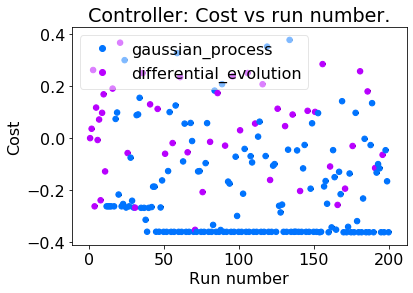

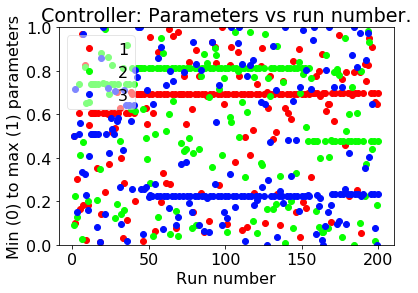

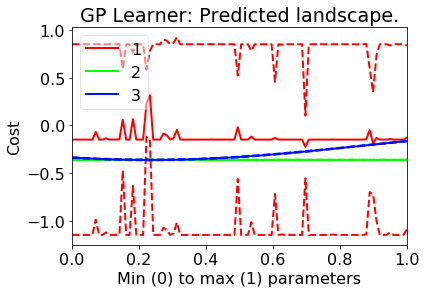

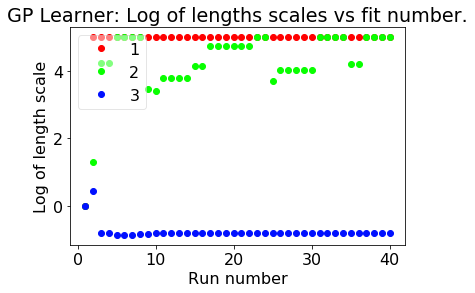

In [8]:
mlv.show_all_default_visualizations(controller)